## Intro

Optical communication has evolved tremendously from the systems based on intensity modulation from just 20 years ago. A modern system will use any number of techniques largely adopted from wireless communications, such as coherent (QAM) modulation and pulse shaping, to boost the spectral efficiency and throughput of the transmission. 

Digital signal processing (DSP) has become a crucial component of these systems to compensate for the impairments which these signals inevitably experience upon propagation, and understanding of the required signal processing is extremely important for running state-of-the-art experiments. While real systems employ custom designed ASICs to cope with the high symbol rates which easily exceed 40 Gbaud, in research and development people largely use offline processing where data is captured using an ultra-fast real-time oscilloscope, such as [this](https://teledynelecroy.com/oscilloscope/labmaster-10-zi-a-oscilloscopes) or [this](https://www.keysight.com/en/pcx-2935671/infiniium-uxr-series-real-time-oscilloscopes?nid=-31885.0&cc=SE&lc=eng), and process the data using matlab typically. 

I am a big Python fan, so the natural thing to do was write our DSP in Python. However, we are typically capture and process large amounts of data (TB are not uncommon) and when running experiments you want quick feedback so you can see the result of a change or adjustment. Therefore you really want to optimise your code for speed. Python as well as Matlab are not fast enough by themselves. At the same time, I want to avoid rewriting in C or C++, because we are scientists first not programmers and I want the PhD students working on this to understand the code without learning C or C++. 

In this notebook we are going explore how to improve performance using cython

### Constant Modulus Algorithm

The problem that we test here is a very common function in communications and optical communications; the adaptive equaliser, which is essentially training an adaptive FIR filter to compensate for channel impairments. The problem is the following: 

Consider a transmitted signal of independently and identically distributed symbols $a(n)$ transmitted through a channel modelled by an FIR filter and addititve white Gaussian noise (AWGN). The received signal can be expressed as:

$$
x(n) = \mathbf{h^H} \mathbf{a}(n) + v(n)
$$
where $\mathbf{a}(n) = [a(n), a(n-1), \dots, (a(n-N+1)]^T$. $\mathbf{h} = [h_0, h_1, \dots, h_{N-1}]^T$ is the vector of the impulse response of the channel, N is the channel length (or memory) and $v(n)$ the additive noise. Note that $x, h, a$ and $v$ are in general complex.

The objective is to find a receiver filter that minimizes inter symbol interference (ISI) and therefore compensates for the channel impairments. The equaliser output then becomes:
$$ 
y(n) = \mathbf{w}^H \mathbf{x}(n)
$$
where $\mathbf{w} = [w_0(n), w_1(n), \dots, w_{N-1}(n)]^T$ is the tap weights of the equaliser impulse response and $\mathbf{x}(n)=[x(n), x(n-1), \dots, x(n-N+1)]^T$ is the equaliser input. 

One of the most famous adaptive blind (without knowledge of the transmitted signal) equalisers is the so-called constant-modulus algorithm (CMA) [1]. It is designed for PSK modulation but is also used as a initial preconvergence algorithm for higher-order QAM signals. The algorithm takes advantage of the fact that the modulus of PSK modulation is a constant, or in other words that PSK modulated symbols lay on a circle in the IQ-plane. The cost function of our equaliser is therefore:
$$ 
J(\mathbf{w})=E \left[ (R-|y(n)|^2)^2] \right]
$$
where $R$ is the radius of the PSK modulation. Using stochastic gradient decent we get an filter update function:

$$
\mathbf{w}(n+1) = \mathbf{w}(n) + \mu y(n)(R-|y(n)|^2) \mathbf{x}^\ast(n)
$$

Here $\mu$ is a step size parameter. 

In optics the channel includes polarisation and therefore we need to extend the algorithm to a $2\times2$ MIMO which is quite straight forward (see e.g. [2])

### References
[1]  D. Godard, “Self-recovering equalization and carrier tracking in two dimensional data communication systems,” IEEE Trans. Commun., vol. 28, pp. 1867–1875 (1980).

[2]  Seb J. Savory, "Digital filters for coherent optical receivers," Opt. Express, vol. 16, pp. 804-817 (2008)

## Simulations and optimizations

To concentrate on the implementation of the CMA algorithm we will use QAMpy for the signal generation and simulation of our system. QAMpy is a is a optical communications DSP chain and simulation toolbox we have written for simulating and processing optical communications signals. You can find it on github [here](https://github.com/ChalmersPhotonicsLab/QAMpy)

## Initialise packages

Let's first import all relevant packages 

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from qampy import signals, impairments, equalisation
import cython 
from timeit import default_timer as timer
%load_ext cython

## Numpy

To establish a performance baseline we are not going to implement the algorithm in pure python, but instead go directly to numpy. 

We are going to separate the CMA algorithm into two functions. A function which applys the filter to the signal and the actual equaliser training, which loops over both polarisations and all samples of the signal. 

### Apply filter
Here is the function that applies the filter to the signal. We'd like to make this as fast as possible because it's being called a lot of times.  Note that we could also implement this as `np.sum(E*wx.conj())` but the below implementation is actually quite a bit faster.

In [2]:
def apply_filter_npy(E,wx):
    Xest = 0 +0j
    for i in range(E.shape[0]):
        Xest += np.dot(E[i], wx[i].conj().T)
    return Xest

### Equaliser training

Here is the training function for the equaliser. It takes 5 parameters the 2d complex signal, the initial equaliser taps (3d) and the step-size mu, radius R (both float constants) and the oversampling factor . Note how we are training the filter for both polarisations in the outer loop. 

In [3]:
def cma_numpy(E, wxy, mu, R, os):
    pols, L = E.shape
    assert wxy.shape[0] == pols
    assert wxy.shape[1] == pols
    ntaps = wxy.shape[-1]
    N = (L//os//ntaps-1)*ntaps
    err = np.zeros((pols, L), dtype=np.complex128)
    for k in range(pols):
        for i in range(N):
            X = E[:, i*os:i*os+ntaps]
            Xest = apply_filter_npy(X, wxy[k])
            err[k,i] = (R-abs(Xest)**2)*Xest
            wxy[k] += mu*np.conj(err[k,i])*X
    return err, wxy 

### Simulation 

Ok lets set up the simulation environment. We are using functions from QAMpy to make signal generation and impairments easier. Feel free to check out the documentation. 

First we set set up the signal which is a dual-polarisation signal with 100,000 symbols and a symbolrate of 10 Gbaud. 

In [4]:
s = signals.SignalQAMGrayCoded(4, 10**5, nmodes=2, fb=10e9)

We are making it easy for us and are only simulating a signal with gaussian noise and pulse-shaping. Thus the adaptive filter is essentially just doing a match-filter. The following code $2\times$ oversamples the signal and applies a root-raised cosine pulse-shape with 1% roll-off. We then change the SNR to 10 dB. 

In [5]:
s2 = s.resample(s.fb*2, beta=0.01)
s3 =  impairments.change_snr(s2, 10)

Let have a look at the constellation diagram.

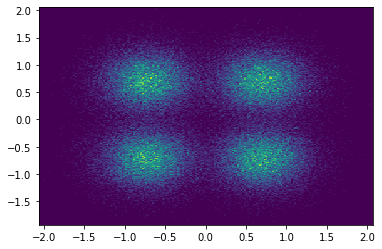

In [6]:
plt.figure()
plt.hist2d(s3[0,::2].real, s3[0,::2].imag, bins=200)
plt.show()

What we see here is a combination of the SNR and the ISI from the lack of matched filtering for the pulse-shaping. We can also calculate the BER. 

In [7]:
s3[:,::2].copy().cal_ber()

array([0.01266 , 0.012585])

This code initialises the filter taps for x and y polarisations to be orthogonal. We are using a filter with 21 taps here and the filter has to have the shape (2,2,21). 

In [8]:
wxy0 = np.zeros((2,2,21), dtype=np.complex128)
wxy0[0][0][21//2] =1
wxy0[1][1][21//2] = 1

So let's time the performance and check the error rate after the filter.

In [9]:
wxyin = wxy0.copy() # we are copying the initial taps so we don't overwrite them
start = timer()
err, wxy = cma_numpy(s3, wxyin, 1e-3, 1, s3.os) 
end=timer()
t_numpy = end-start
print("Numpy time = {:.3f}".format(t_numpy))
out = equalisation.apply_filter(s3, wxy)
print("BER = {}".format(out.cal_ber()))

Numpy time = 5.484
BER = [0.00109511 0.00123012]


Numpy took about 5.5 s for processing the 100,000 symbols. We can also see that the adaptive filter improved performance by a factor of 10. 

Generally 100,000 symbols is on the lower end of what we measure and 5 s is quite a wait so we really want to go faster than this. 

## Cython

The most well known way to improve python performance is to use [cython](https://cython.org) which is a superset of the python language and can be compiled straight to C yielding some impressive performance improvements. The performance critical parts of QAMpy are written in cython at the moment. Below is the straight direct translation of the above numpy code into cython, note we have made the apply_filter function a C-only function (indicated by the `cdef`), because we don't need to call it from python. We also disabled array boundary checks and wraparound which speeds up loops significantly. 

In [10]:
%%cython
import numpy as np
cimport numpy as np
import cython

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
cdef double complex apply_filter_pyx(np.ndarray[np.complex128_t, ndim=2] E, np.ndarray[np.complex128_t, ndim=2] wx):
    cdef int j, k, M, N
    cdef double complex Xest =0
    M = E.shape[0]
    for i in range(M):
        Xest += np.dot(E[i], np.conj(wx[i]))
    return Xest


@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def cma_pyx1(np.ndarray[np.complex128_t, ndim=2] E, np.ndarray[np.complex128_t, ndim=3] wxy, double mu, double R, int os):
    cdef int i,j,k,pols, N, ntaps
    cdef np.ndarray[np.complex128_t, ndim=2] err
    cdef np.ndarray[np.complex128_t, ndim=2] X
    cdef double complex Xest
    ntaps = wxy.shape[2]
    pols = E.shape[0]
    L = E.shape[1]
    N = (L//os//ntaps-1)*ntaps
    err = np.zeros((pols, L), dtype=np.complex128)
    for k in range(pols):
        for i in range(N):
            X = E[:, i*os:i*os+ntaps]
            Xest = apply_filter_pyx(X, wxy[k])
            err[k,i] = (R-abs(Xest)**2)*Xest
            wxy[k] += mu*np.conj(err[k,i])*X
    return err,wxy

Let us see if that improved performance

In [11]:
start = timer()
err, wxy = cma_pyx1(s3, wxyin, 1e-3, 1, s3.os)
end=timer()
t_cython1 = end-start
print("Cython initial time = {:.3f}".format(t_cython1))
out = equalisation.apply_filter(s3, wxy)
print("BER = {}".format(out.cal_ber()))

Cython initial time = 4.651
BER = [0.00122512 0.00122512]


This is rather disappointing. It took 4.7s on my maching so only a very modest speedup. 

#### Cython annotate 
Let's have a look why. Cython offers  `-a` commandline switch which outputs an annotated html file highlighting the sections which contain calls to python code. Those sections are in general the bottlenecks and you want to eliminate as many as possible of those, so that the code runs at pure C-code speed.

In [12]:
%%cython -a
import numpy as np
cimport numpy as np
import cython

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
cdef double complex apply_filter_pyx(np.ndarray[np.complex128_t, ndim=2] E, np.ndarray[np.complex128_t, ndim=2] wx):
    cdef int j, k, M, N
    cdef double complex Xest =0
    M = E.shape[0]
    for i in range(M):
        Xest += np.dot(E[i], np.conj(wx[i]))
    return Xest


@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def cma_pyx1(np.ndarray[np.complex128_t, ndim=2] E, np.ndarray[np.complex128_t, ndim=3] wxy, double mu, double R, int os):
    cdef int i,j,k,pols, N, ntaps
    cdef np.ndarray[np.complex128_t, ndim=2] err
    cdef np.ndarray[np.complex128_t, ndim=2] X
    cdef double complex Xest
    ntaps = wxy.shape[2]
    pols = E.shape[0]
    L = E.shape[1]
    N = (L//os//ntaps-1)*ntaps
    err = np.zeros((pols, L), dtype=np.complex128)
    for k in range(pols):
        for i in range(N):
            X = E[:, i*os:i*os+ntaps]
            Xest = apply_filter_pyx(X, wxy[k])
            err[k,i] = (R-abs(Xest)**2)*Xest
            wxy[k] += mu*np.conj(err[k,i])*X
    return err,wxy

As you can see there are still yellow sections insight the tight loops. To really optimize for speed we want to eliminate those. Let me show you the fully optimized code first and then explain the different bits. 

#### Optimized cython code

In [13]:
%%cython -c=-Ofast -c=-ffast-math -c=-mfpmath=sse -c=-funroll-loops -c=-march=native
import numpy as np
cimport numpy as cnp
import cython

cdef extern from "complex.h" nogil:
    double complex conj(double complex)

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
cdef double complex apply_filter_pyx(double complex[:,:] E, double complex[:,:] wx) nogil:
    cdef int j, k, M, N
    cdef double complex Xest = 0
    M = E.shape[0]
    N = E.shape[1]
    for i in range(M):
        for j in range(N):
            Xest += E[i,j] * conj(wx[i,j])
    return Xest


@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def cma_pyx1(double complex[:,:] E, double complex[:,:,:] wxy, double mu, double R, int os):
    cdef int i,j,l,k,pols, N, ntaps
    cdef double complex[:,:] err
    cdef double complex[:,:] X
    cdef double complex Xest
    ntaps = wxy.shape[2]
    pols = E.shape[0]
    L = E.shape[1]
    N = (L//os//ntaps-1)*ntaps
    err = np.zeros((pols, L), dtype=np.complex128)
    for k in range(pols):
        for i in range(N):
            X = E[:, i*os:i*os+ntaps]
            Xest = apply_filter_pyx(X, wxy[k])
            err[k,i] = (R-abs(Xest)**2)*Xest
            for j in range(pols):
                for l in range(ntaps):
                    wxy[k, j, l] = wxy[k, j, l] + mu * conj(err[k, i])*X[j,l]
    return err,wxy



In [14]:
start = timer()
err, wxy = cma_pyx1(s3, wxyin, 1e-3, 1, s3.os)
end=timer()
t_cython1 = end-start
print("Cython initial time = {:.3f}".format(t_cython1))
out = equalisation.apply_filter(s3, wxy)
print("BER = {}".format(out.cal_ber()))

Cython initial time = 0.029
BER = [0.00140514 0.00122512]


Now this took only about 0.03 seconds on my PC. A speed-up of more than a factor 100. That's quite sizable! Let's have a look again at the annotated output.

In [15]:
%%cython -a
import numpy as np
cimport numpy as cnp
import cython

cdef extern from "complex.h" nogil:
    double complex conj(double complex)

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
cdef double complex apply_filter_pyx(double complex[:,:] E, double complex[:,:] wx):
    cdef int j, k, M, N
    cdef double complex Xest =0
    M = E.shape[0]
    N = E.shape[1]
    for i in range(M):
        for j in range(N):
            Xest += E[i,j] * conj(wx[i,j])
    return Xest


@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def cma_pyx1(double complex[:,:] E, double complex[:,:,:] wxy, double mu, double R):
    cdef int i,j,k,pols, N, ntaps,os
    cdef double complex[:,:] err
    cdef double complex[:,:] X
    cdef double complex Xest
    os = 2
    ntaps = wxy.shape[2]
    pols = E.shape[0]
    L = E.shape[1]
    N = (L//os//ntaps-1)*ntaps
    err = np.zeros((pols, L), dtype=np.complex128)
    for k in range(pols):
        for i in range(N):
            X = E[:, i*os:i*os+ntaps]
            Xest = apply_filter_pyx(X, wxy[k])
            err[k,i] = (R-abs(Xest)**2)*Xest
            for j in range(pols):
                for l in range(ntaps):
                    wxy[k, j, l] = wxy[k, j, l] + mu * conj(err[k, i])*X[j,l]
    return err,wxy



As you can see we have eliminated all the yellow sections inside the loops. So let's step through the optimizations

### Unroll loops

The first thing you want to do is unroll the loops. Therefore in `apply_filter` 

```python
for i in range(M):
    Xest += np.dot(E[i], np.conj(wx[i]))
```
becomes:
```python
for i in range(M):
    for j in range(N):
        Xest += E[i,j] * np.conj(wx[i,j])
```

and in `cma_pyx1` 

```python
wxy[k] += mu*np.conj(err[k,i])*X
```

becomes:

```python
for j in range(pols):
    for l in range(ntaps):
        wxy[k, j, l] = wxy[k, j, l] + mu * np.conj(err[k, i])*X[j,l]
```


### Use C-functions in loops

The problem with the above code is that we still call `np.conj` inside the tight loop and that's a python function. So to eliminate that we have to import the c-function and use that like so:

```python
cdef extern from "complex.h" nogil:
    double complex conj(double complex)
```

This imports the complex conjugate function `conj` from the standard library and we then use that instead inside the loops. 

### Compiler flags

You might have also noticed the compiler flags. I did quite a bit of testing and this set did yield a significant speed gain, however the gains can be application specific and you should test yourself. A word of caution -ffast-math enables transformations that are not strictly IEEE compliant. However, this is not an issue for our use-case. Generally, in the processing here we have SNRs which are way below floating point precision. In fact we could (and often do) run code in single precision and see absolutely no difference.  

### Parallelisation

It would also be possible to parallise the loop over the two polarisations. Interestingly enough that did reduce my performance slightly so I did not do it here. 


## Conclusion

Using Cython we can achieve a more than 100 times speed-up compared to the numpy version. That's quite a sizable performance gain and for us it's the difference between being almost "real-time" why we are adjusting our experiment and it being completely unusable. However, it comes at a cost. I would argue the optimized cython code is significantly more complex with a lot of boilerplate. So it somewhat defeats the purpose of using Python in the first place. In a later post I will explore other methods for speeding up the code.
